# Parallax Tutorial 02

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/ophusgroup/apmc2025-4dstem-workshop/blob/main/notebooks/try-it-yourself/03.parallax_02.ipynb)

This is the second tutorial notebook in the parallax series.  
In this tutorial notebook we will cover:
- Subpixel upsampling
- Aberration fitting and correction

### Downloads
This tutorial uses the following datasets:
- [parallax_apoferritin_simulation.h5](https://drive.google.com/file/d/1hr-fhseEr5XnWWVc4V6gNKXNYQwAoPez/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated: 2025 Feb 01

In [1]:
%pip install py4DSTEM > /dev/null 2>&1

In [2]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)
%matplotlib inline

cupyx.jit.rawkernel is experimental. The interface can change in the future.


0.14.18


### Cross-Correlation Alignment

First, we load the infinite-dose dataset, add Poisson noise equal to 50e/Å$^2$, and reconstruct as in the previous tutorial.

In [3]:
# Get the 4DSTEM data
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1hr-fhseEr5XnWWVc4V6gNKXNYQwAoPez',
    destination = '/content/',
    filename = 'parallax_apoferritin_simulation.h5',
    overwrite=True
)

Downloading...
From (original): https://drive.google.com/uc?id=1hr-fhseEr5XnWWVc4V6gNKXNYQwAoPez
From (redirected): https://drive.google.com/uc?id=1hr-fhseEr5XnWWVc4V6gNKXNYQwAoPez&confirm=t&uuid=2798924c-69e9-4812-b199-8d429c0ef367
To: /content/parallax_apoferritin_simulation.h5
100%|██████████| 349M/349M [00:08<00:00, 39.7MB/s]


In [4]:
file_path = '/content/'
file_data = file_path + 'parallax_apoferritin_simulation.h5'

dataset = py4DSTEM.read(file_data)

np.random.seed(1234)
area_per_probe = dataset.calibration.get_R_pixel_size()**2
dataset.data = np.random.poisson((dataset.data * 50 * area_per_probe).clip(0)).astype(np.uint64)

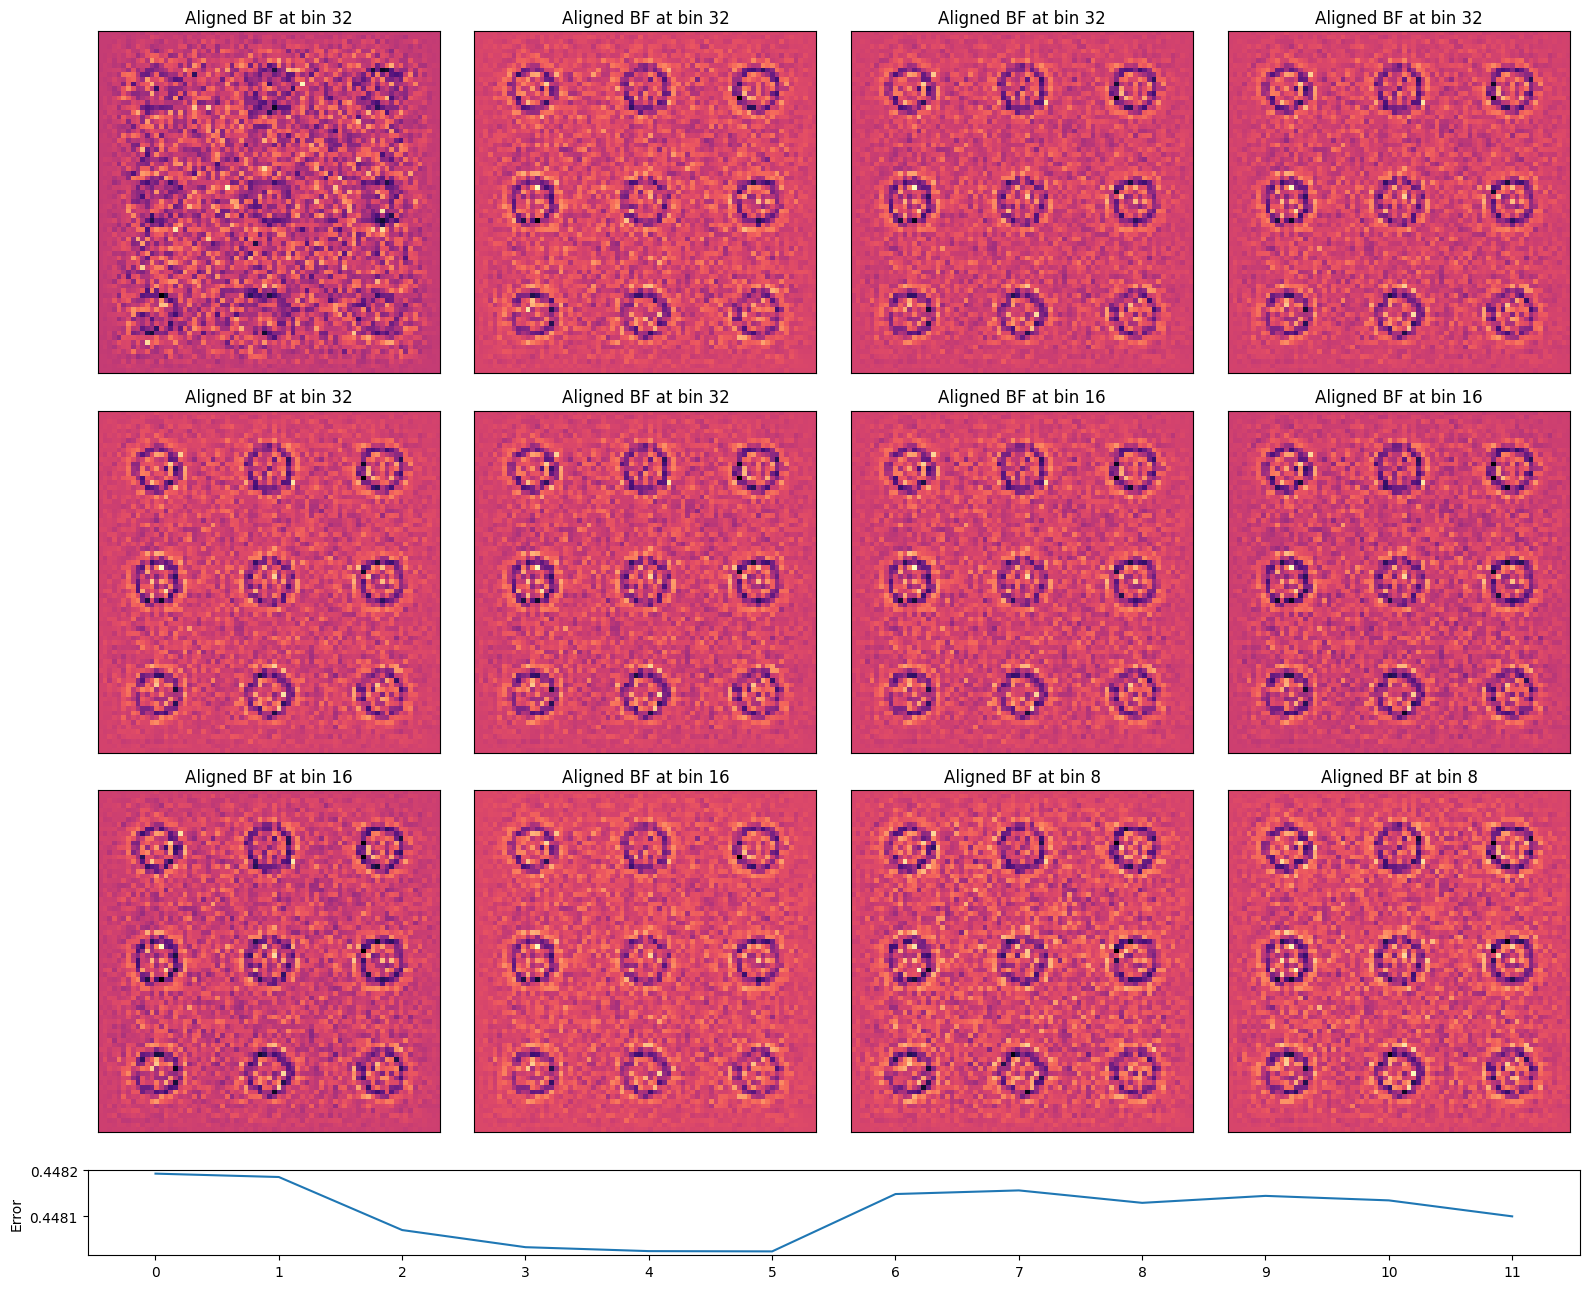

In [5]:
parallax = py4DSTEM.process.phase.Parallax(
    datacube=dataset,
    energy = 300e3,
    device = "cpu",
    object_padding_px=(16,16),
).preprocess(
    edge_blend=8,
    plot_average_bf=False,
).reconstruct(
    alignment_bin_values=[32,32,32,32,32,32,16,16,16,16,8,8],
    regularize_shifts=False,
    progress_bar=False,
)

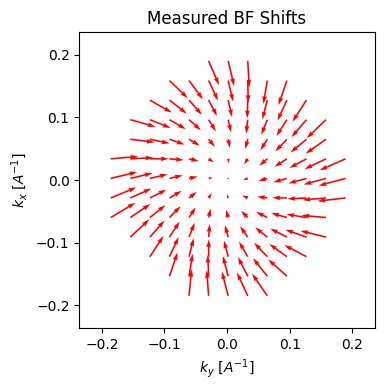

In [6]:
parallax.show_shifts(
    plot_arrow_freq=4, # plot every 4th arrow for clarity
)

### Subpixel Upsampling
The cross-correlation shifts have subpixel accuracy, so we can use them to improve the real-space sampling of our reconstructed image.

Here, we use kernel-density estimation to improve the real-space sampling (and thus the information limit) of our reconstruction.

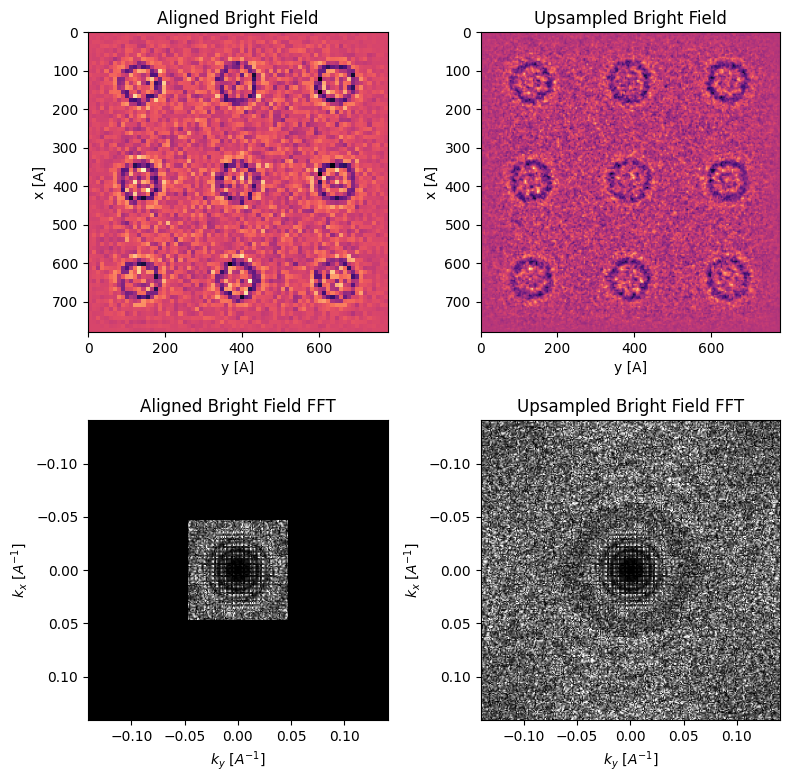

In [7]:
parallax = parallax.subpixel_alignment(
    kde_upsample_factor=3,
    plot_upsampled_BF_comparison=True,
    plot_upsampled_FFT_comparison=True,
)

It might be slightly hard to see due to the low dose used, but there's additional Thon ring oscillations past the initial 0.05 k Å$^1$ Nyquist limit of the scan sampling.  
Here we perfom an angular average to illustrate these Fourier intensity modulations:

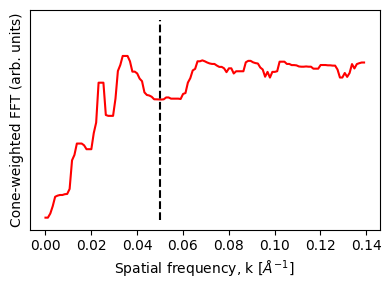

In [8]:
from scipy.ndimage import median_filter

def cone_weighted_fft(array, sampling):
    nx, ny = array.shape
    kx = np.fft.fftfreq(nx, d=sampling)
    ky = np.fft.fftfreq(ny, d=sampling)
    k = np.sqrt(kx[:, None] ** 2 + ky[None, :] ** 2)
    return np.abs(np.fft.fft2(array))*k, k

def cone_weighted_radial_fft(array, sampling, median_filter_radius):
    fft, k = cone_weighted_fft(array,sampling)
    radial_fft = py4DSTEM.process.phase.utils.cartesian_to_polar_transform_2Ddata(
        fft,
        xy_center=(0,0),
        corner_centered=True
    )
    radial_fft_filtered = median_filter(radial_fft.sum(0),median_filter_radius)
    return k[:radial_fft_filtered.shape[0],0], radial_fft_filtered

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(
    *cone_weighted_radial_fft(
        parallax.recon_BF_subpixel_aligned,
        parallax._scan_sampling[0] / parallax._kde_upsample_factor,
        5
    ),
    color='red'
)

ax.vlines(0.05,0,50,linestyles='dashed',colors='black')
ax.set_yticks([])
ax.set_xlabel(r"Spatial frequency, k [$\AA^{-1}$]")
ax.set_ylabel("Cone-weighted FFT (arb. units)")

fig.tight_layout();

The aligned BF image has contrast equivalent to HRTEM images:

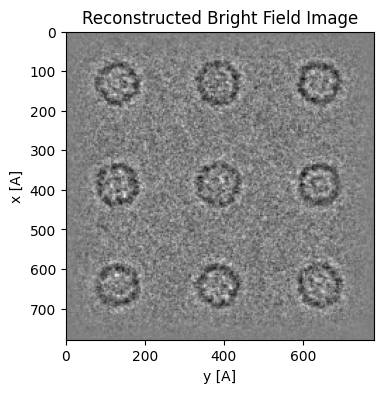

In [9]:
parallax = parallax.visualize(
    upsampled=True,
    figsize=(4,4),
    cmap='grey',
)

This means that if we want to process the dataset further, e.g. in single-particle analysis software like cryosparc or Relion, we need to correct its contrast transfer function (CTF).  
To do this, we first need to estimate the CTF by fitting the probe aberrations.

### Aberration Fitting
The cross-correlation vector field is proportial to the gradient of the aberration surface, so we can use them to fit aberration coefficients!

         Initial aberration coefficients          
--------------------------------------------------
  rotation   transpose    C1      stig  stig angle
   [deg]       ---       [Ang]   [Ang]     [deg]  
----------   -------   -------   -----   ---------
  -14.2       False    -15715     603      -16.9  

         Refined aberration coefficients          
--------------------------------------------------
aberration    radial   angular   angle   magnitude
   name       order     order    [deg]     [Ang]  
----------   -------   -------   -----   ---------
    C1          2         0       ---     -15707  
   stig         2         2      -16.5      605   


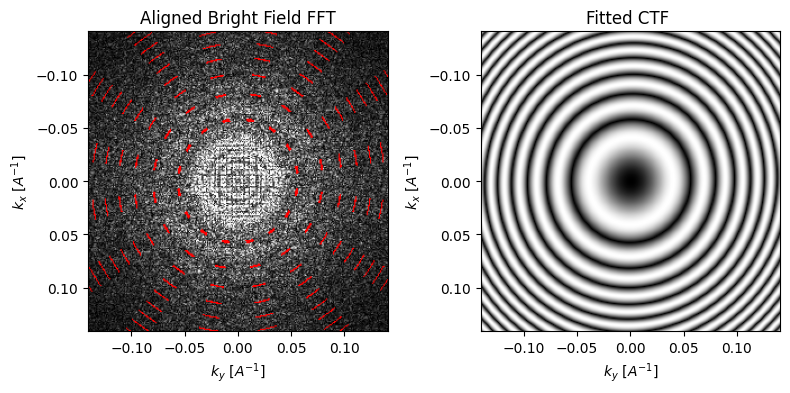

In [10]:
parallax = parallax.aberration_fit(
    max_radial_order=2,
    plot_CTF_comparison=True,
)

The first thing the algorithm does is deconvolve the cross-correlation shifts to a rotational and a scaling component, using a polar decomposition.
The scaling component is then used to fit the aberration coefficients.

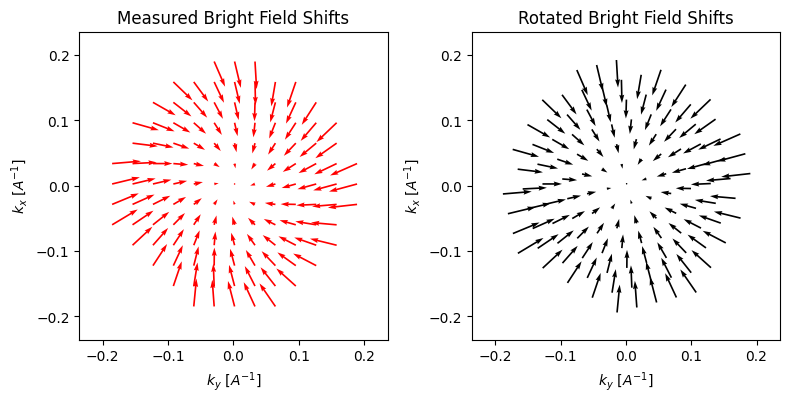

In [11]:
parallax.show_shifts(
    plot_arrow_freq=4, # plot every 4th arrow for clarity
)

If we invoke `show_shifts` again, then we obtain a visual representation of the two effects. The plot on the right is properly rotated, such that the shifts are radially outwards. And indeed, even with our very noisy dataset, the algorithm does fairly well at estimating both the rotation (measured: -16.9°, actual: -15°) and the defocus (measured: 1.57um, actual: 1.5um).

In [12]:
parallax.aberrations_dict_polar

{'C10': -15706.893721504004,
 'C12': 605.029053682972,
 'phi12': -0.28838783584749333}

### Higher-order Aberration Fitting

You might've noticed the output above also reported "refined aberration coefficients".  
What we're doing here is construct an aberrations coefficients basis up a specified radial and angular order, and then fit their gradients against the calculated cross-correlation shifts.  

Note the initial polar decomposition fit may (default) or may not be used as an initial guess.

         Initial aberration coefficients          
--------------------------------------------------
  rotation   transpose    C1      stig  stig angle
   [deg]       ---       [Ang]   [Ang]     [deg]  
----------   -------   -------   -----   ---------
  -14.2       False    -15715     603      -16.9  

         Refined aberration coefficients          
--------------------------------------------------
aberration    radial   angular   angle   magnitude
   name       order     order    [deg]     [Ang]  
----------   -------   -------   -----   ---------
    C1          2         0       ---     -15695  
   stig         2         2      -16.4      606   
   coma         3         1      -157.7    119000  
 trefoil        3         3      23.6       257   
    C3          4         0       ---    -2671463 
  stig2         4         2      -69.8    1622800 


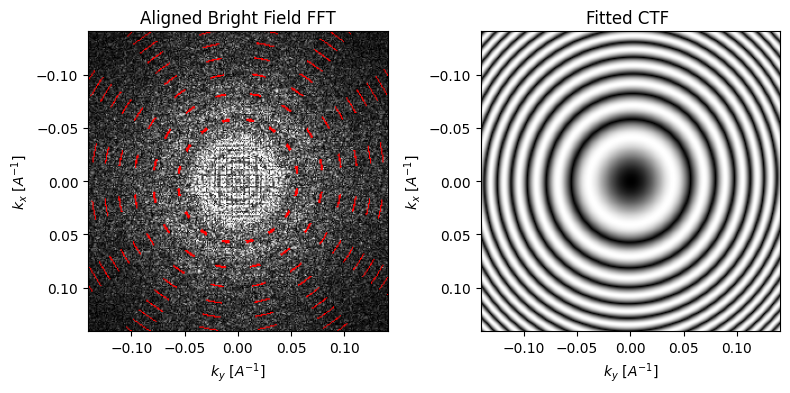

In [13]:
parallax = parallax.aberration_fit(
    max_radial_order=4,
    max_angular_order=3,
    # initialize_fit_with_polar_decomposition = False,
    plot_CTF_comparison=True,
)

Notice that while our simulation only has defocus, the (relatively) small coefficients fitted to higher-order do not affect the fitted CTF much.

### Aberration Correction

We can now use the fitted CTF to correct our reconstruction by "phase-flipping" the negative portions of the CTF.
This will lead to "dark-field" like contrast - as dictated be scattering physics.

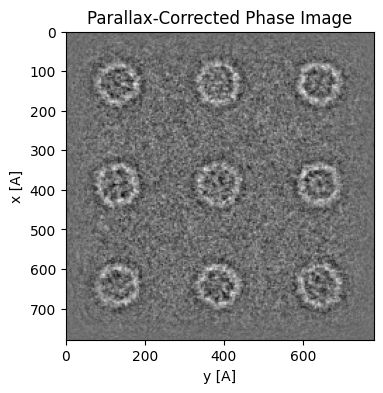

In [14]:
parallax = parallax.aberration_correct(
    figsize=(4,4),
    cmap='grey'
)

## Skipping Cross-correlation / Manual alignment

Remember from `parallax_01.ipynb` that for very noisy datasets cross-correlation can fail to align the dataset

In [15]:
np.random.seed(1234)

dataset_noisier = py4DSTEM.read(file_data)
dataset_noisier.data = np.random.poisson((dataset_noisier.data * 10 * area_per_probe).clip(0)).astype(np.uint64)

Note that if we somehow knew the geometry (rotation/transpose) and aberration coefficients, then we can pass those in `preprocess` and initialization respectively, and set the horizontal shifts analytically without having to use cross-correlation to estimate them.

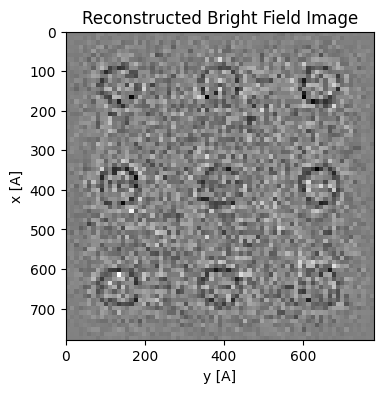

In [16]:
parallax_noisier = py4DSTEM.process.phase.Parallax(
    datacube=dataset_noisier,
    energy = 300e3,
    device = "cpu",
    object_padding_px=(16,16),
    defocus=1.5e4,
).preprocess(
    edge_blend=8,
    plot_average_bf=False,
    force_rotation_angle_deg=-15,
).visualize(
    figsize=(4,4),
    cmap='grey',
)

This suggests that we can "manually align" our virtual BFs, by playing around with common aberration coefficients.  
The utility function `guess_common_aberrations` (to be called after `preprocess`), wraps the steps above and gives visual outputs to guide you to do that.

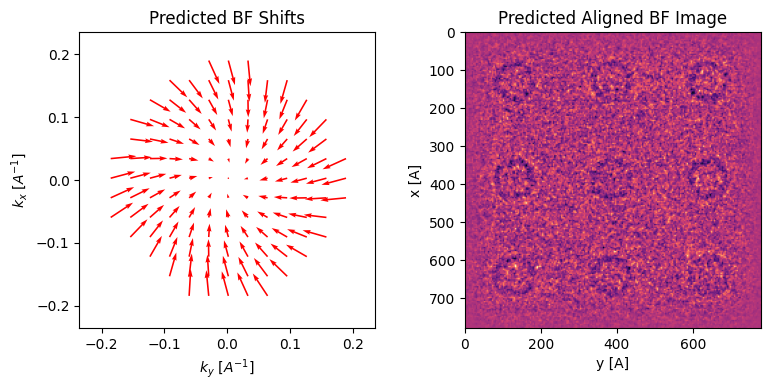

In [17]:
parallax_noisier.guess_common_aberrations(
    rotation_angle_deg=-15,
    defocus=1.5e4,
    plot_arrow_freq=4,
    kde_upsample_factor=3,
)

For example, if you have ipywidgets installed, the following wrapper is a convenient way to guess these:

In [19]:
# import ipywidgets

# def widget_wrapper(rotation_angle_deg,defocus,upsampling_factor):
#     """ wrapper to only pass interactive sliders of interest """
#     return parallax_noisier.guess_common_aberrations(
#         rotation_angle_deg = rotation_angle_deg,
#         defocus = defocus,
#         kde_upsample_factor=upsampling_factor,
#         plot_arrow_freq=4,

#     )

# rotation_slider = ipywidgets.FloatSlider(value=-15,min=-90,max=90,continuous_update=False,description="rotation [°]")
# defocus_slider = ipywidgets.FloatSlider(value=1.5e4,min=-3e4,max=3e4,continuous_update=False,description="defocus [Å]")
# upsampling_slider = ipywidgets.FloatSlider(value=3,min=1,max=4,continuous_update=False,description="upsampling")

# ipywidgets.interact(
#     widget_wrapper,
#     rotation_angle_deg=rotation_slider,
#     defocus=defocus_slider,
#     upsampling_factor=upsampling_slider,
# );